In [1]:
# Problem Statement

# Tasks / Goals


#  Imports & settings

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.options.display.max_columns = None

# Load the dataset

In [3]:

df = pd.read_excel("Flight_Fare.xlsx")   # adjust filename if needed
print("Shape:", df.shape)
df.head()


Shape: (10683, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Quick info & missing values

In [4]:

print(df.info())
display(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None


Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

# EDA: basic statistics and target distribution

count    10683.000000
mean      9087.064121
std       4611.359167
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64

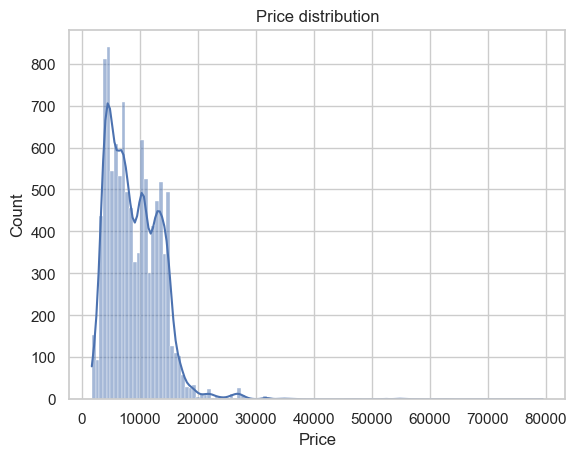

In [5]:

if 'Price' in df.columns:
    display(df['Price'].describe())
    sns.histplot(df['Price'], kde=True)
    plt.title('Price distribution')
    plt.show()
else:
    print("No 'Price' column detected. Replace with correct target column name.")


#  Show unique values for small-cardinality columns

In [6]:

for col in df.columns:
    n = df[col].nunique()
    if n <= 20:
        print(f"{col:25} | unique: {n} | {df[col].unique()[:20]}")
    else:
        print(f"{col:25} | unique: {n}")


Airline                   | unique: 12 | ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
Date_of_Journey           | unique: 44
Source                    | unique: 5 | ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Destination               | unique: 6 | ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']
Route                     | unique: 128
Dep_Time                  | unique: 222
Arrival_Time              | unique: 1343
Duration                  | unique: 368
Total_Stops               | unique: 5 | ['non-stop' '2 stops' '1 stop' '3 stops' nan '4 stops']
Additional_Info           | unique: 10 | ['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 Short layover' 'No Info' '1 Long layover' 'Change airports'
 'Business class' 'Red-eye flight' '2 Long layover']
Price                     | unique: 1870


# Feature engineering 

In [7]:
#  Feature engineering for flight datasets (common columns)
# This block handles common patterns: Date_of_Journey, Dep_Time, Arrival_Time, Duration, Total_Stops
# It is robust: checks presence before attempting transformations.

def parse_date_time_cols(df):
    df = df.copy()
    # Date_of_Journey -> day, month
    if 'Date_of_Journey' in df.columns:
        df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], errors='coerce', dayfirst=True)
        df['Journey_Day'] = df['Date_of_Journey'].dt.day
        df['Journey_Month'] = df['Date_of_Journey'].dt.month

    # Dep_Time and Arrival_Time -> hour, minute
    for col, pref in [('Dep_Time','Dep'), ('Arrival_Time','Arr')]:
        if col in df.columns:
            # some may include only time, so try to parse
            df[col + '_parsed'] = pd.to_datetime(df[col].astype(str), format='%H:%M', errors='coerce').dt.time
            # fallback parsing any datetime-like string
            df[col + '_dt'] = pd.to_datetime(df[col], errors='coerce')
            df[pref + '_Hour'] = df[col + '_dt'].dt.hour.fillna(0).astype(int)
            df[pref + '_Min'] = df[col + '_dt'].dt.minute.fillna(0).astype(int)

    # Duration -> convert to total minutes
    if 'Duration' in df.columns:
        # Duration values like "2h 50m" or "2h" or "50m"
        def duration_to_mins(x):
            if pd.isna(x): return np.nan
            s = str(x).strip()
            hours = 0
            mins = 0
            if 'h' in s:
                try:
                    hours = int(s.split('h')[0].strip())
                    rest = s.split('h')[1]
                except:
                    hours = 0
                    rest = s
            else:
                rest = s
            if 'm' in rest:
                try:
                    mins = int(rest.replace('m','').strip())
                except:
                    mins = 0
            return hours*60 + mins
        df['Duration_mins'] = df['Duration'].apply(duration_to_mins)
    
    # Total_Stops -> numeric: 'non-stop' -> 0, '1 stop' -> 1 etc.
    if 'Total_Stops' in df.columns:
        def stops_to_int(x):
            if pd.isna(x): return np.nan
            s = str(x).strip().lower()
            if s in ['non-stop', 'non stop', 'nonstop', '0 stops', '0 stop', '0']:
                return 0
            try:
                # handle "1 stop", "2 stops"
                return int([int(i) for i in s.split() if i.isdigit()][0])
            except:
                # fallback for "1 stop"
                if '1' in s: return 1
                if '2' in s: return 2
                if '3' in s: return 3
                return np.nan
        df['Total_Stops_Num'] = df['Total_Stops'].apply(stops_to_int)
    return df

df = parse_date_time_cols(df)
df.head()


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_parsed,Dep_Time_dt,Dep_Hour,Dep_Min,Arrival_Time_parsed,Arrival_Time_dt,Arr_Hour,Arr_Min,Duration_mins,Total_Stops_Num
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22:20:00,2026-01-29 22:20:00,22,20,NaT,2026-03-22 01:10:00,1,10,170,0.0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,05:50:00,2026-01-29 05:50:00,5,50,13:15:00,2026-01-29 13:15:00,13,15,445,2.0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,09:25:00,2026-01-29 09:25:00,9,25,NaT,2026-06-10 04:25:00,4,25,1140,2.0
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,18:05:00,2026-01-29 18:05:00,18,5,23:30:00,2026-01-29 23:30:00,23,30,325,1.0
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,16:50:00,2026-01-29 16:50:00,16,50,21:35:00,2026-01-29 21:35:00,21,35,285,1.0


#  Handle missing values

In [8]:
#  Handle missing values (simple but robust approach)
# Strategy:
# - Drop rows where target (Price) is missing
# - For numeric engineered features: fill with median
# - For categorical: fill with 'Unknown' or 'No Info'

# drop rows where Price missing
if 'Price' in df.columns:
    df = df[df['Price'].notna()].copy()

# fill for engineered numerical columns
num_fill_cols = [c for c in ['Duration_mins','Total_Stops_Num','Journey_Day','Journey_Month','Dep_Hour','Dep_Min','Arr_Hour','Arr_Min'] if c in df.columns]
for col in num_fill_cols:
    df[col] = df[col].fillna(df[col].median())

# fill categorical nulls
cat_cols_guess = ['Airline','Source','Destination','Route','Additional_Info']
for c in cat_cols_guess:
    if c in df.columns:
        df[c] = df[c].fillna('No Info')

# check again
display(df.isnull().sum())


Airline                   0
Date_of_Journey           0
Source                    0
Destination               0
Route                     0
Dep_Time                  0
Arrival_Time              0
Duration                  0
Total_Stops               1
Additional_Info           0
Price                     0
Journey_Day               0
Journey_Month             0
Dep_Time_parsed           0
Dep_Time_dt               0
Dep_Hour                  0
Dep_Min                   0
Arrival_Time_parsed    4335
Arrival_Time_dt           0
Arr_Hour                  0
Arr_Min                   0
Duration_mins             0
Total_Stops_Num           0
dtype: int64

# select features

In [9]:
#  Create final feature set (select features to use)
# Typical features to include:
features = []
# always include numeric engineered features if present
for c in ['Duration_mins','Total_Stops_Num','Journey_Day','Journey_Month','Dep_Hour','Dep_Min','Arr_Hour','Arr_Min']:
    if c in df.columns:
        # note: Dep_Hour column name in parse_date_time_cols is 'Dep_Hour' or 'Dep_Hour'? check actual
        # our parse used 'Dep_Hour' prefix - we used 'Dep' prefix earlier.
        # check actual names
        for actual in df.columns:
            if actual.lower().startswith(c.lower()):
                pass
        features.append(c)

# include categorical columns if present
for c in ['Airline','Source','Destination','Route','Additional_Info']:
    if c in df.columns:
        features.append(c)

# Remove duplicates & keep order
features = [f for i,f in enumerate(features) if f not in features[:i]]
print("Using features:", features)


Using features: ['Duration_mins', 'Total_Stops_Num', 'Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Min', 'Arr_Hour', 'Arr_Min', 'Airline', 'Source', 'Destination', 'Route', 'Additional_Info']


# Categorical & Numerical Lists

Correlation with Price:


Price              1.000000
Total_Stops_Num    0.603883
Duration_mins      0.506371
Arr_Hour           0.024264
Dep_Hour           0.006819
Dep_Min           -0.024492
Arr_Min           -0.086155
Journey_Month     -0.103651
Journey_Day       -0.153738
Name: Price, dtype: float64

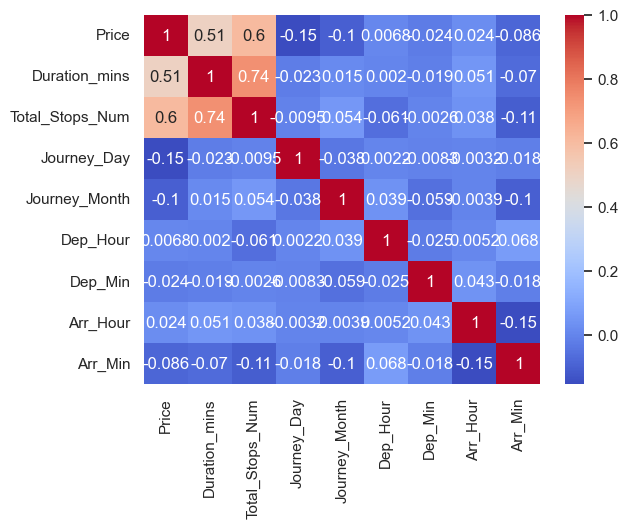

In [10]:
# Cell 9 - Quick correlation for numeric features with Price
num_features = [c for c in features if c in df.select_dtypes(include=np.number).columns]
if num_features:
    print("Correlation with Price:")
    display(df[['Price']+num_features].corr()['Price'].sort_values(ascending=False))
    sns.heatmap(df[['Price']+num_features].corr(), annot=True, cmap='coolwarm')
    plt.show()


In [11]:
#  Prepare X, y
X = df[features].copy()
y = df['Price'].astype(float)
X.shape, y.shape


((10683, 13), (10683,))

In [12]:
# Define categorical and numerical lists properly for the pipeline
categorical_cols = [c for c in X.columns if X[c].dtype == 'object']
numerical_cols = [c for c in X.columns if c not in categorical_cols]
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info']
Numerical: ['Duration_mins', 'Total_Stops_Num', 'Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Min', 'Arr_Hour', 'Arr_Min']


# Build preprocessing pipeline

In [13]:

from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='No Info')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])


#  Train/Test split

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape)


(8546, 13) (2137, 13)


# Train Candidate Models

In [15]:

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = {}
trained_pipelines = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
    trained_pipelines[name] = pipe
    print(f"{name}: R2={r2:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}")


LinearRegression: R2=0.7449, MAE=1578.31, RMSE=2323.74
RandomForest: R2=0.8895, MAE=599.19, RMSE=1529.59
GradientBoosting: R2=0.8216, MAE=1293.48, RMSE=1942.87


#  Compare & choose best by R2

In [16]:

results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
display(results_df)
best_model_name = results_df.index[0]
best_pipeline = trained_pipelines[best_model_name]
print("Best Model:", best_model_name)


,R2,MAE,RMSE
RandomForest,0.889451,599.185250,1529.593174
GradientBoosting,0.821644,1293.481295,1942.866008
LinearRegression,0.744861,1578.308409,2323.739117


Best Model: RandomForest


# Final evaluation on test set & save metrics

In [17]:

y_test_pred = best_pipeline.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred)
final_mae = mean_absolute_error(y_test, y_test_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Final model ({best_model_name}) performance on test set:")
print("R2:", final_r2)
print("MAE:", final_mae)
print("RMSE:", final_rmse)

metrics = {
    'Model': best_model_name,
    'R2': final_r2,
    'MAE': final_mae,
    'RMSE': final_rmse
}
pd.DataFrame([metrics]).to_excel("model_performance.xlsx", index=False)


Final model (RandomForest) performance on test set:
R2: 0.889451000268347
MAE: 599.1852496648247
RMSE: 1529.5931739551168


#  Feature importances ( tree models)

In [18]:

try:
    # Extract feature names after preprocessing
    ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    numeric_feature_names = numerical_cols
    all_feature_names = numeric_feature_names + cat_feature_names

    # get importances
    model_step = best_pipeline.named_steps['model']
    if hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
        fi = pd.DataFrame({'Variable': all_feature_names, 'Feature Importance Score': importances})
        fi = fi.sort_values('Feature Importance Score', ascending=False).reset_index(drop=True)
        fi.to_excel("feature_importance.xlsx", index=False)
        display(fi.head(30))
    else:
        print("Model has no feature_importances_ attribute (e.g., LinearRegression).")
except Exception as e:
    print("Could not compute importances:", e)


,Variable,Feature Importance Score
0,Duration_mins,0.441208
1,Journey_Day,0.095065
2,Additional_Info_In-flight meal not included,0.075406
3,Airline_Jet Airways Business,0.060615
4,Airline_Jet Airways,0.056714
5,Journey_Month,0.044618
6,Total_Stops_Num,0.026819
7,Route_BLR → BOM → DEL,0.025369
8,Arr_Hour,0.018906
9,Dep_Hour,0.017450


# Save model  

In [19]:

import joblib
joblib.dump(best_pipeline, "flight_price_model.pkl")
print("Saved model pipeline to flight_price_model.pkl")


Saved model pipeline to flight_price_model.pkl


# Add predictions & export

In [20]:

df['Predicted_Price'] = best_pipeline.predict(df[features])
df.to_excel("flight_data_with_predictions.xlsx", index=False)
print("Exported predictions to flight_data_with_predictions.xlsx")


Exported predictions to flight_data_with_predictions.xlsx


In [22]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [26]:
import pandas as pd

prophet_df = df[['Date_of_Journey', 'Price']].copy()
prophet_df.columns = ['ds', 'y']



In [27]:
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], dayfirst=True)


In [28]:
prophet_df = prophet_df.dropna()


In [29]:
prophet_df = prophet_df.groupby('ds', as_index=False)['y'].mean()


In [30]:
prophet_df.head()
prophet_df.dtypes


ds    datetime64[ns]
y            float64
dtype: object

In [31]:
from prophet import Prophet

model = Prophet()
model.fit(prophet_df)


19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:53 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
future = model.make_future_dataframe(periods=60)


In [33]:
forecast = model.predict(future)


In [34]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
90,2019-08-17,5894.977587,2432.031947,9602.637217
91,2019-08-18,6532.247434,2728.087396,9875.443804
92,2019-08-19,6051.274752,2474.954779,9497.928942
93,2019-08-20,5954.040506,2502.780614,9471.509593
94,2019-08-21,5804.297024,2189.629879,9361.736763
95,2019-08-22,6234.804658,3007.135515,9659.751645
96,2019-08-23,5955.010047,2411.895938,9654.198665
97,2019-08-24,5757.404729,2194.830072,9658.065384
98,2019-08-25,6394.674576,2879.664921,9762.569946
99,2019-08-26,5913.701893,2559.558946,9512.376977


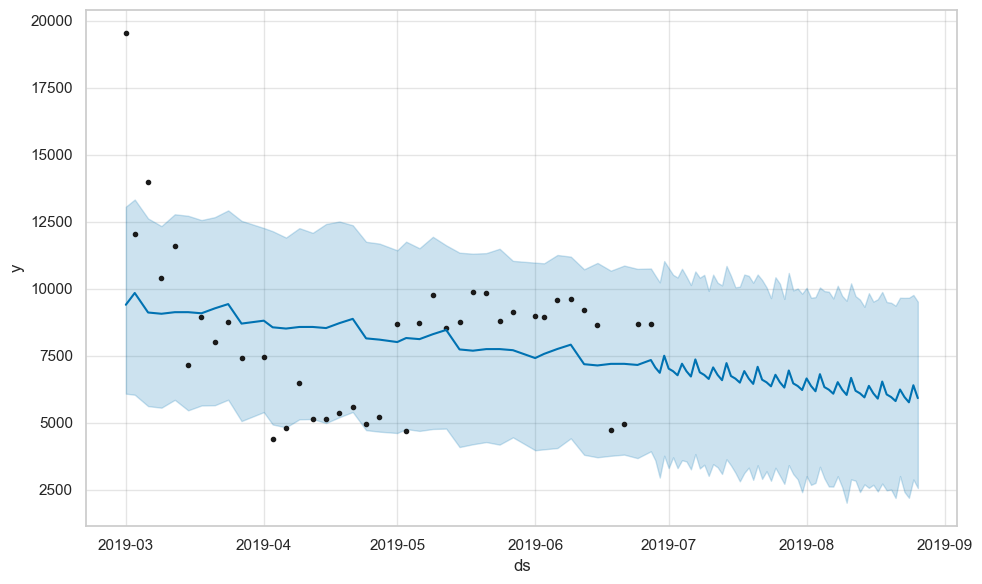

In [35]:
import matplotlib.pyplot as plt
model.plot(forecast)
plt.show()


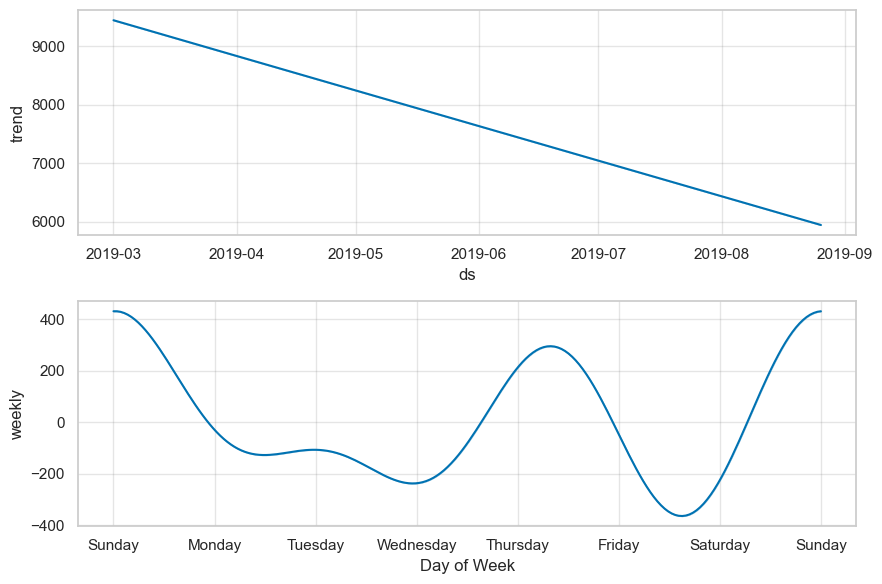

In [36]:
model.plot_components(forecast)
plt.show()


In [37]:
forecast[['ds', 'yhat']].to_excel("prophet_future_prices.xlsx", index=False)


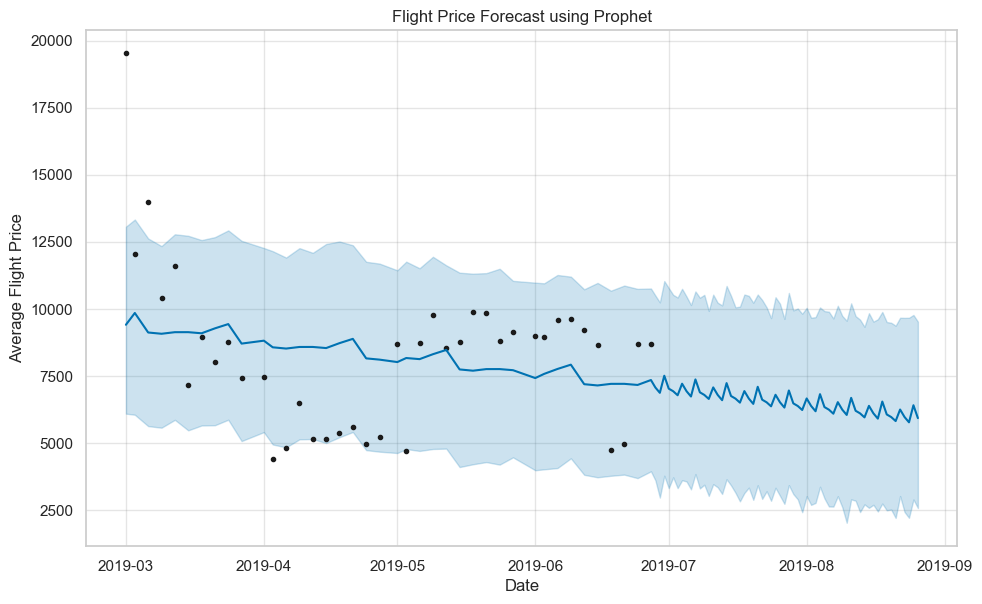

In [38]:
import matplotlib.pyplot as plt

model.plot(forecast)
plt.title("Flight Price Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Average Flight Price")
plt.show()


In [40]:
actual_df = df[['Date_of_Journey', 'Price']].copy()
actual_df['Date_of_Journey'] = pd.to_datetime(actual_df['Date_of_Journey'], dayfirst=True)

# Daily average actual price
actual_df = actual_df.groupby('Date_of_Journey', as_index=False)['Price'].mean()
actual_df.columns = ['ds', 'actual_price']

In [42]:
compare_df = forecast[['ds', 'yhat']].merge(
    actual_df,
    on='ds',
    how='left'
)


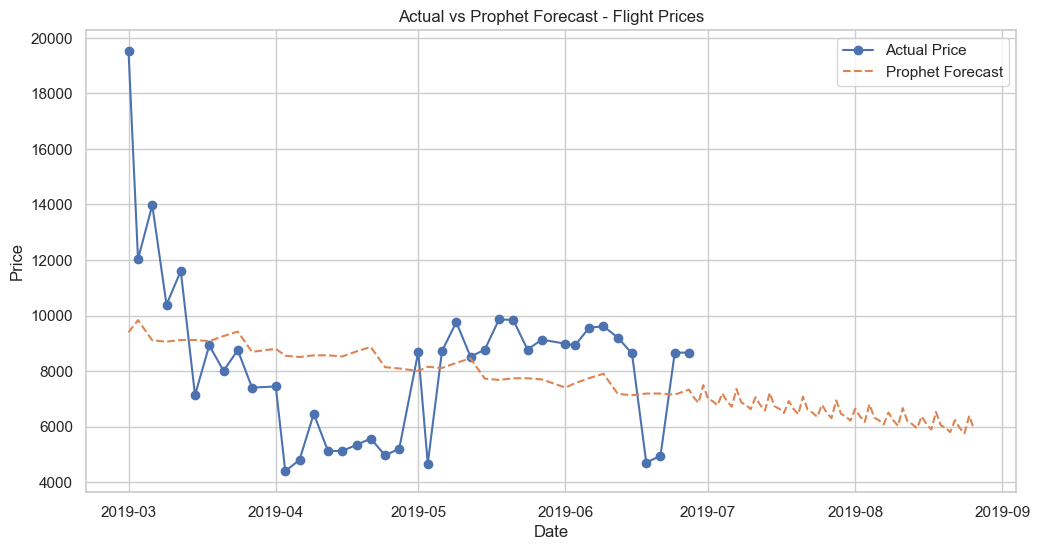

In [43]:
plt.figure(figsize=(12,6))
plt.plot(compare_df['ds'], compare_df['actual_price'], label='Actual Price', marker='o')
plt.plot(compare_df['ds'], compare_df['yhat'], label='Prophet Forecast', linestyle='--')
plt.legend()
plt.title("Actual vs Prophet Forecast - Flight Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [44]:
compare_df.to_excel("actual_vs_prophet_prices.xlsx", index=False)
print("Actual vs Prophet comparison exported to Excel")


Actual vs Prophet comparison exported to Excel
